<a href="https://colab.research.google.com/github/phongidoit/CS114_assignment/blob/main/OCR_eval_training.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Import all relevant data

In [1]:
from google.colab import drive
drive.mount('/content/drive', force_remount= False)

Mounted at /content/drive


In [2]:
%%capture
!mkdir /content/data
!mkdir /content/data
!mkdir /content/data/icdar15_eval

#train file
!unzip  '/content/drive/MyDrive/data ML/CS114/Train.zip' -d /content/data

#eval file
!unzip  '/content/drive/MyDrive/data ML/CS114/Eval.zip'  -d /content/data

#icdar_15 evalutation file
!unzip  '/content/drive/MyDrive/data ML/ICDAR/ch4_test_word_images_gt.zip' -d /content/data/icdar15_eval
!wget -P  /content/data/icdar15_eval https://paddleocr.bj.bcebos.com/dataset/rec_gt_test.txt

## Preprocess the data

In [3]:
#@title Format icdar15 label file

!touch /content/test_gt.txt
file_new = open("/content/data/icdar15_eval/icdar_15.txt",'a')
with open('/content/data/icdar15_eval/rec_gt_test.txt', 'r', encoding='utf-8-sig') as labels:
  for line in labels:
    data = line.split("\t")
    file_name = data[0].split("/")[1]

    file_new.write( "/content/data/icdar15_eval"+file_name+'\t"'+data[1][:-1]+'"'+'\n')

!rm /content/data/icdar15_eval/rec_gt_test.txt

In [ ]:
#utility function
import json
def read_json(object):
  pass

##Download and try detection model

In [4]:
%%capture
!git clone https://github.com/PaddlePaddle/PaddleOCR.git
!pip install -r PaddleOCR/requirements.txt
!pip install install paddlepaddle-gpu==2.3.2 -i https://mirror.baidu.com/pypi/simple

In [5]:
#@title Test on 3 detection model
%%capture
!mkdir /content/pretrain_model
!mkdir /content/pretrain_model/detection

!wget https://paddleocr.bj.bcebos.com/PP-OCRv3/chinese/ch_PP-OCRv3_det_slim_infer.tar
!wget https://paddleocr.bj.bcebos.com/PP-OCRv3/chinese/ch_PP-OCRv3_det_infer.tar
!wget https://paddleocr.bj.bcebos.com/PP-OCRv2/chinese/ch_PP-OCRv2_det_infer.tar

!tar -xf /content/ch_PP-OCRv3_det_slim_infer.tar  -C /content/pretrain_model/detection
!tar -xf /content/ch_PP-OCRv3_det_infer.tar -C /content/pretrain_model/detection
!tar -xf /content/ch_PP-OCRv2_det_infer.tar -C /content/pretrain_model/detection
!rm ch_PP-OCRv3_det_slim_infer.tar
!rm ch_PP-OCRv3_det_infer.tar
!rm ch_PP-OCRv2_det_infer.tar

In [ ]:
#@title IOU calculate function

def area(rec):
  return (rec[1][0]-rec[0][0]) * (rec[1][1] - rec[0][1])

def overlap_lenght(a1, a2, b1, b2):
  if b1>= a2 or a1 >= b2:
    return 0
  elif  b1 >= a1:
    return min(a2, b2) -b1
  else:
    return min(a2, b2) - a1


def IOU(true, pred):
  intersect = overlap_lenght(true[0][0], true[1][0], pred[0][0], pred[1][0]) * overlap_lenght(true[0][1], true[1][1], pred[0][1], pred[1][1])

  return round(intersect/(area(true)+ area(pred)-intersect), 4)

In [ ]:
# use this func to convert from paddle polygon to rectangle
def covert_to_rec(box):
  box = np.array(box).astype(np.int32)
  x_min = min(box[:,0])
  y_min = min(box[:,1])
  x_max = max(box[:,0])
  y_max = max(box[:,1])
  return [[x_min, y_min],[x_max, y_max]]

def read_pos(cell):
  value =  json.loads(cell)
  return [value['x'], value['y'], value['width'], value['height']]

def csv_to_rec(csv_box):
  x,y,w,h = csv_box
  return [[x, y], [x+w, y+h]]

In [13]:
#@title Get the OCR ready
%%capture
!pip install paddleocr
from paddleocr import PaddleOCR
model = PaddleOCR(use_angle_cls=False, lang='en', det_model_dir='/content/pretrain_model/detection/ch_PP-OCRv3_det_infer' ,use_gpu=False)

In [ ]:
#testing ground here
result = model.ocr('/content/data/Train/Images/1.jpg', det=True, rec=False)
print(len(result[0]))

3


In [ ]:
#@title Run through the bounding box to evaluate
import json
import pandas as pd
import numpy as np

img_path=""
file = pd.read_csv('/content/data/Train/label_data.csv')

all_iou = []
img_head="/content/data/Train/Images/"
for id, row in file.iterrows():

  if row['filename'] != img_path:
    img_path = row['filename']
    #detect on new image
    det_boxes= model.ocr(img_head+img_path, cls=False, det=True, rec=False)[0]
    det_boxes = [ covert_to_rec(box)  for box in det_boxes]

  #convert csv box to standard box
  #print(row['region_shape_attributes'])

  b_box = csv_to_rec(read_pos(row['region_shape_attributes']))

  max_iou = 0
  for box in det_boxes:
    iou = IOU(b_box, box)

    if iou > max_iou:
      max_iou = iou

  all_iou.append(max_iou)

print("Average IOU:", sum(all_iou)/len(all_iou))

Average IOU: 0.7488159784560146


In [ ]:
print(all_iou)

[0, 0.0424, 0.0317, 0.8511, 0.2371, 0.0305, 0.0195, 0.2682, 0.1647, 0.1115, 0.0825, 0.0723, 0, 0, 0.3564, 0, 0.4352, 0.0678, 0, 0, 0, 0, 0, 0.0482, 0.5614, 0.1256, 0.0984, 0.0713, 0.0611, 0.0645, 0.0511, 0.0568, 0.1215, 0.0885, 0.0143, 0.0197, 0.1233, 0.3017, 0.2422, 0.1412, 0.0528, 0, 0, 0, 0.187, 0.092, 0.0678, 0, 0, 0, 0, 0, 0, 0, 0, 0.5219, 0.4551, 0.2277, 0.0172, 1.0605, 0, 0.1739, 0.0646, 0.0691, 0.4029, 0.2655, 0.1437, 0.3225, 0.1681, 0.1627, 0.0201, 0, 0, 0, 0.0512, 0.042, 0, 0, 0, 0, 0, 0.5433, 0.0518, 0.0462, 0.0253, 0.0981, 0.0863, 0.0568, 0.0493, 0.0558, 0.0512, 0.0529, 0.0852, 0.071, 0.0925, 0.0503, 0, 0, 0.0454, 0.0322, 0.0175, 0.1147, 0.0993, 0.0675, 0.1654, 0.4533, 0, 0.0345, 0, 0.3555, 0.2689, 0.1825, 0.1615, 0.0455, 0.0661, 0, 0, 0.1729, 0.113, 0.0553, 0.0415, 0.0309, 0.0239, 0.0234, 0.0271, 0.03, 0.0338, 0.0098, 0.0165, 0.019, 0.0189, 0.0979, 0.054, 0.0215, 0.5007, 0.2092, 0, 0.5753, 0.1944, 0.1233, 0.0948, 0.2696, 0.0816, 0, 0, 10.938, 0.5682, 0.1608, 0.1181, 0.0957

In [ ]:
#@title On another detection model

model_2 = PaddleOCR(use_angle_cls=False, lang='en', det_model_dir="/content/pretrain_model/detection/ch_PP-OCRv3_det_slim_infer" ,use_gpu=False)
#result = model.ocr(image, cls=False, det=True, rec=False)

In [ ]:
img_path=""
file = pd.read_csv('/content/data/Train/label_data.csv')

all_iou = []
img_head="/content/data/Train/Images/"
for id, row in file.iterrows():

  if row['filename'] != img_path:
    img_path = row['filename']
    #detect on new image
    det_boxes= model_2.ocr(img_head+img_path, cls=False, det=True, rec=False)[0]
    det_boxes = [ covert_to_rec(box)  for box in det_boxes]

  #convert csv box to standard box

  b_box = csv_to_rec(read_pos(row['region_shape_attributes']))

  max_iou = 0
  for box in det_boxes:
    iou = IOU(b_box, box)

    if iou > max_iou:
      max_iou = iou

  all_iou.append(max_iou)

print("Average IOU:", sum(all_iou)/len(all_iou))

Average IOU: 0.7527174147217232


In [ ]:
#@title Third detection model
model_3 = PaddleOCR(use_angle_cls=False, lang='en', det_model_dir="/content/pretrain_model/detection/ch_PP-OCRv2_det_infer" ,use_gpu=False)
#result = model.ocr(image, cls=False, det=True, rec=False)

In [ ]:
img_path=""
file = pd.read_csv('/content/data/Train/label_data.csv')

all_iou = []
img_head="/content/data/Train/Images/"
for id, row in file.iterrows():

  if row['filename'] != img_path:
    img_path = row['filename']
    #detect on new image
    det_boxes= model_3.ocr(img_head+img_path, cls=False, det=True, rec=False)[0]
    det_boxes = [ covert_to_rec(box)  for box in det_boxes]

  #convert csv box to standard box

  b_box = csv_to_rec(read_pos(row['region_shape_attributes']))

  max_iou = 0
  for box in det_boxes:
    iou = IOU(b_box, box)

    if iou > max_iou:
      max_iou = iou

  all_iou.append(max_iou)

print("Average IOU:", sum(all_iou)/len(all_iou))

Average IOU: 0.6623116696588861


[[77, 98], [415, 172]]
[[80, 187], [416, 238]]
[[104, 252], [384, 303]]


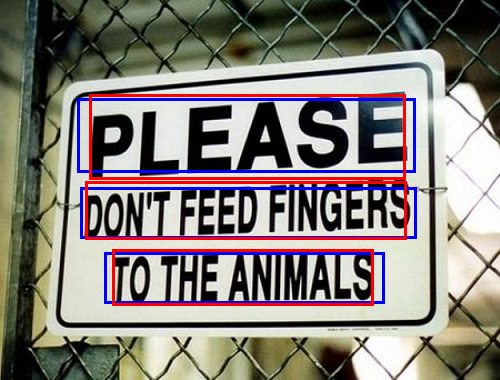

In [ ]:
#@title Sample image

def quick_conv(box_l):
  return ((box_l[0][0], box_l[0][1]), (box_l[1][0], box_l[1][1]))
#blue for true and red for predict
from PIL import Image, ImageDraw
img_path = "/content/data/Train/Images/1.jpg"
img_name= img_path.split("/")[-1]
det_boxes = model_2.ocr(img_path, cls=False, det=True, rec=False)[0]
det_boxes = [covert_to_rec(box) for box in det_boxes]

true_boxes_row = file[file.filename==img_name]
#print(true_boxes_row.head())
true_boxes=[]
for id,row in true_boxes_row.iterrows():
  true_boxes.append(csv_to_rec(read_pos(row['region_shape_attributes'])))

Img = Image.open(img_path)
draw = ImageDraw.Draw(Img)
for box in true_boxes:
  print(box)
  draw.rectangle(quick_conv(box), outline='blue', width=3)

for box in det_boxes:
  draw.rectangle(quick_conv(box), outline='red', width=3)

#Img.paste(draw,(0,0))
Img.show()

## Download and run recognition model

In [7]:
#@title Pretrain inference model for evaluation
%%capture

!wget https://paddleocr.bj.bcebos.com/PP-OCRv3/chinese/ch_PP-OCRv3_rec_infer.tar
!tar -xf /content/ch_PP-OCRv3_rec_infer.tar -C /content/pretrain_model/recognition/
!rm ch_PP-OCRv3_rec_infer.tar

In [6]:
#@title Recognition data & config for recognition
%%capture
!unzip  '/content/drive/MyDrive/data ML/CS114/Train_crop.zip' -d /content/data
!unzip  '/content/drive/MyDrive/data ML/CS114/Eval_crop.zip' -d /content/data
!touch /content/PaddleOCR/configs/rec/custom_train.yml

In [26]:
#@title Load pretrained model
%%capture
model_reg=PaddleOCR(use_angle_cls=True, rec_model_dir='/content/pretrain_model/recognition/ch_PP-OCRv3_rec_infer' ,use_gpu=False)

In [ ]:
#@title Run evaluation on eval dataset
eval_label_path="/content/data/Eval_crop/label.txt"
score=0
n_line=0

with open(eval_label_path) as label_file:
  for line in label_file:
    img_path = line.split('\t')[0]
    true_text = line.split('\t')[1] [1:-2]

    try:
      result = model_reg.ocr(img_path, cls=True ,det=False, rec=True)
    except:
      continue
    #convert result here
    predict_text= result[0][0][0]
    if predict_text[0]==" ":
      predict_text=predict_text[1:]
    if true_text[len(true_text)-1] == " ":
      #print('here')
      true_text=predict_text[:len(true_text)-1]

    #break

    if true_text == predict_text:
      score+=1
    else:
      print(predict_text)
      print(true_text+"*")
    n_line+=1

print("Accuracy:", round(score/n_line, 4) )

##Train recognition model

In [8]:
%%capture
!wget https://paddleocr.bj.bcebos.com/PP-OCRv3/english/en_PP-OCRv3_rec_train.tar

In [9]:
!mkdir /content/pretrain_model/recognition
!tar -xf en_PP-OCRv3_rec_train.tar -C  /content/pretrain_model/recognition

In [ ]:
#@title Config file
#paste the file in this file: /content/PaddleOCR/configs/rec/custom_train.yml

"""
Global:
  use_gpu: true
  epoch_num: 120
  log_smooth_window: 20
  print_batch_step: 20
  save_model_dir: /content/output_model/Custom/
  save_epoch_step: 5
  # evaluation is run every 2000 iterations
  eval_batch_step: [0, 2000]
  cal_metric_during_train: Yes
  pretrained_model: /content/pretrain_model/recognition/en_PP-OCRv3_rec_slim_train/best_accuracy
  checkpoints:
  save_inference_dir: ./
  use_visualdl: False
  infer_img: doc/imgs_words_en/word_10.png
  # for data or label process
  character_dict_path: /content/PaddleOCR/ppocr/utils/en_dict.txt
  max_text_length: 80
  infer_mode: false
  use_space_char: true
  save_res_path: ./output/rec/predicts_custom.txt

Optimizer:
  name: Adam
  beta1: 0.9
  beta2: 0.999
  lr:
    learning_rate: 0.001
  regularizer:
    name: 'L2'
    factor: 0

Architecture:
  model_type: rec
  algorithm: CRNN
  Transform:
  Backbone:
    name: MobileNetV3
    scale: 0.5
    model_name: large
  Neck:
    name: SequenceEncoder
    encoder_type: rnn
    hidden_size: 96
  Head:
    name: CTCHead
    fc_decay: 0

Loss:
  name: CTCLoss

PostProcess:
  name: CTCLabelDecode

Metric:
  name: RecMetric
  main_indicator: acc

Train:
  dataset:
    name: SimpleDataSet
    data_dir: /content/data/Train_crop/Images
    label_file_list: ["/content/data/Train_crop/label.txt"]
    transforms:
      - DecodeImage: # load image
          img_mode: BGR
          channel_first: False
      - CTCLabelEncode: # Class handling label
      - RecResizeImg:
          image_shape: [3, 32, 100]
      - KeepKeys:
          keep_keys: ['image', 'label', 'length'] # dataloader will return list in this order
  loader:
    shuffle: True
    batch_size_per_card: 256
    drop_last: True
    num_workers: 8
    use_shared_memory: False

Eval:
  dataset:
    name: SimpleDataSet
    data_dir: /content/data/Eval_crop/Images
    label_file_list: ["/content/data/Eval_crop/label.txt"]
    transforms:
      - DecodeImage: # load image
          img_mode: BGR
          channel_first: False
      - CTCLabelEncode: # Class handling label
      - RecResizeImg:
          image_shape: [3, 32, 100]
      - KeepKeys:
          keep_keys: ['image', 'label', 'length'] # dataloader will return list in this order
  loader:
    shuffle: False
    drop_last: False
    batch_size_per_card: 256
    num_workers: 4
    use_shared_memory: False
"""


In [ ]:
#@title Config 2

"""
Global:
  debug: false
  use_gpu: true
  epoch_num: 50
  log_smooth_window: 20
  print_batch_step: 10
  save_model_dir: /content/output_model/Custom/
  save_epoch_step: 3
  eval_batch_step: [0, 2000]
  cal_metric_during_train: true
  pretrained_model:
  checkpoints:
  save_inference_dir:
  use_visualdl: false
  infer_img: doc/imgs_words/ch/word_1.jpg
  character_dict_path: /content/PaddleOCR/ppocr/utils/en_dict.txt
  max_text_length: &max_text_length 60
  infer_mode: false
  use_space_char: true
  distributed: true
  save_res_path: ./output/rec/predicts_ppocrv3_en.txt

Optimizer:
  name: Adam
  beta1: 0.9
  beta2: 0.999
  lr:
    name: Cosine
    learning_rate: 0.001
    warmup_epoch: 5
  regularizer:
    name: L2
    factor: 3.0e-05

Architecture:
  model_type: rec
  algorithm: SVTR
  Transform:
  Backbone:
    name: MobileNetV1Enhance
    scale: 0.5
    last_conv_stride: [1, 2]
    last_pool_type: avg
  Head:
    name: MultiHead
    head_list:
      - CTCHead:
          Neck:
            name: svtr
            dims: 64
            depth: 2
            hidden_dims: 120
            use_guide: True
          Head:
            fc_decay: 0.00001
      - SARHead:
          enc_dim: 512
          max_text_length: *max_text_length

Loss:
  name: MultiLoss
  loss_config_list:
    - CTCLoss:
    - SARLoss:

PostProcess:
  name: CTCLabelDecode

Metric:
  name: RecMetric
  main_indicator: acc
  ignore_space: False

Train:
  dataset:
    name: SimpleDataSet
    data_dir: /content/data/Train_crop/Images
    ext_op_transform_idx: 1
    label_file_list: ["/content/data/Train_crop/label.txt"]
    transforms:
    - DecodeImage:
        img_mode: BGR
        channel_first: false
    - RecConAug:
        prob: 0.5
        ext_data_num: 2
        image_shape: [48, 320, 3]
        max_text_length: *max_text_length
    - RecAug:
    - MultiLabelEncode:
    - RecResizeImg:
        image_shape: [3, 48, 320]
    - KeepKeys:
        keep_keys:
        - image
        - label_ctc
        - label_sar
        - length
        - valid_ratio
  loader:
    shuffle: true
    batch_size_per_card: 128
    drop_last: true
    num_workers: 4
Eval:
  dataset:
    name: SimpleDataSet
    data_dir: /content/data/Eval_crop/Images
    label_file_list: ["/content/data/Eval_crop/label.txt"]
    transforms:
    - DecodeImage:
        img_mode: BGR
        channel_first: false
    - MultiLabelEncode:
    - RecResizeImg:
        image_shape: [3, 48, 320]
    - KeepKeys:
        keep_keys:
        - image
        - label_ctc
        - label_sar
        - length
        - valid_ratio
  loader:
    shuffle: false
    drop_last: false
    batch_size_per_card: 128
    num_workers: 4
"""

In [10]:
!python3 /content/PaddleOCR/tools/train.py \
  -c /content/PaddleOCR/configs/rec/custom_train.yml

Streaming output truncated to the last 5000 lines.
[2023/07/15 15:01:25] ppocr ERROR: When parsing line /content/data/Train_crop/Images/269.JPG	GEORGE ORWELL
, error happened with msg: Traceback (most recent call last):
  File "/content/PaddleOCR/ppocr/data/simple_dataset.py", line 136, in __getitem__
    data['ext_data'] = self.get_ext_data()
  File "/content/PaddleOCR/ppocr/data/simple_dataset.py", line 102, in get_ext_data
    label = substr[1]
IndexError: list index out of range

[2023/07/15 15:01:29] ppocr ERROR: When parsing line /content/data/Train_crop/Images/133.jpg	GAMES
, error happened with msg: Traceback (most recent call last):
  File "/content/PaddleOCR/ppocr/data/simple_dataset.py", line 136, in __getitem__
    data['ext_data'] = self.get_ext_data()
  File "/content/PaddleOCR/ppocr/data/simple_dataset.py", line 102, in get_ext_data
    label = substr[1]
IndexError: list index out of range

[2023/07/15 15:01:29] ppocr ERROR: When parsing line 
, error happened with msg: 

In [21]:
#@title Convert model to interference

!mkdir /content/own_model/

!python3 /content/PaddleOCR/tools/export_model.py -c /content/PaddleOCR/configs/rec/custom_train.yml\
 -o Global.pretrained_model=/content/pretrain_model/recognition/en_PP-OCRv3_rec_train/best_accuracy  Global.save_inference_dir=/content/own_model/custom_rec_0/

mkdir: cannot create directory ‘/content/own_model/’: File exists
/usr/local/lib/python3.10/dist-packages/pkg_resources/__init__.py:121: DeprecationWarning: pkg_resources is deprecated as an API
  warnings.warn("pkg_resources is deprecated as an API", DeprecationWarning)
/usr/local/lib/python3.10/dist-packages/pkg_resources/__init__.py:2870: DeprecationWarning: Deprecated call to `pkg_resources.declare_namespace('google')`.
Implementing implicit namespace packages (as specified in PEP 420) is preferred to `pkg_resources.declare_namespace`. See https://setuptools.pypa.io/en/latest/references/keywords.html#keyword-namespace-packages
  declare_namespace(pkg)
/usr/local/lib/python3.10/dist-packages/pkg_resources/__init__.py:2870: DeprecationWarning: Deprecated call to `pkg_resources.declare_namespace('google.cloud')`.
Implementing implicit namespace packages (as specified in PEP 420) is preferred to `pkg_resources.declare_namespace`. See https://setuptools.pypa.io/en/latest/references/keyw

In [17]:
!python3 -m paddle.distributed.launch --gpus '0' /content/PaddleOCR/tools/eval.py -c /content/PaddleOCR/configs/rec/custom_train.yml\
 -o Global.checkpoints=/content/output_model/Custom/latest

/usr/local/lib/python3.10/dist-packages/pkg_resources/__init__.py:121: DeprecationWarning: pkg_resources is deprecated as an API
  warnings.warn("pkg_resources is deprecated as an API", DeprecationWarning)
/usr/local/lib/python3.10/dist-packages/pkg_resources/__init__.py:2870: DeprecationWarning: Deprecated call to `pkg_resources.declare_namespace('google')`.
Implementing implicit namespace packages (as specified in PEP 420) is preferred to `pkg_resources.declare_namespace`. See https://setuptools.pypa.io/en/latest/references/keywords.html#keyword-namespace-packages
  declare_namespace(pkg)
/usr/local/lib/python3.10/dist-packages/pkg_resources/__init__.py:2870: DeprecationWarning: Deprecated call to `pkg_resources.declare_namespace('google.cloud')`.
Implementing implicit namespace packages (as specified in PEP 420) is preferred to `pkg_resources.declare_namespace`. See https://setuptools.pypa.io/en/latest/references/keywords.html#keyword-namespace-packages
  declare_namespace(pkg)
/usr

In [24]:
model_reg2=PaddleOCR(use_angle_cls=True, lang='en', rec_model_dir='/content/own_model/custom_rec_0', use_gpu=False,)

download https://paddleocr.bj.bcebos.com/PP-OCRv3/english/en_PP-OCRv3_det_infer.tar to /root/.paddleocr/whl/det/en/en_PP-OCRv3_det_infer/en_PP-OCRv3_det_infer.tar


100%|██████████| 4.00M/4.00M [00:13<00:00, 291kiB/s] 


In [27]:
#@title run evaluation on trained model
eval_label_path="/content/data/Eval_crop/label.txt"
score=0
n_line=0

with open(eval_label_path) as label_file:
  for line in label_file:
    img_path = line.split('\t')[0]
    true_text = line.split('\t')[1] [1:-2]

    try:
      result = model_reg2.ocr(img_path, cls=True ,det=False, rec=True)
    except:
      continue

    #convert result here
    predict_text= result[0][0][0]
    if predict_text[0]==" ":
      predict_text=predict_text[1:]
    if true_text[len(true_text)-1] == " ":
      #print('here')
      true_text=true_text[:len(true_text)-1]

    #break

    if true_text.lower() == predict_text.lower():
      score+=1
    else:
      print(predict_text)
      print(true_text+"*")
    n_line+=1

print("Accuracy:", round(score/n_line, 4) )

MORE PHECISE EVENFASTER.
MORE PRECISE EVEN FASTER*
CUTTNG SOUTIONS
CUTTING SOLUTIONS*
CROUP
GROUP*
Rudiger Dornbusch
Rudiger Dornbush*
Cartier
Carlier*
LINES!
LINES*
TEKTILES
TEXTILES*
PaRTo
ParTy*
PEANUTCRACKERS
PEANUT CRACKERS*
CHeSSSeT
CHESS SET*
Farmer tech problem.ourtechmission
Farmer tech problem, our tech mision*
There werealot of paintings of monkeys waving bamboo sticks in the galery.
There were a lot of paintings of monkeys waving bamboo sticks in the gallery.*
The dead trees waited to be ignited by the smallest spark and seek their
The dead trees waited to be ignited by the smallest spark and seek their *
I had a friend in high school named Rick Shaw, but he was fairly useless.
I had a friend in high school named Rick Shaw but he was fairly useless*
PUT SAND IN OTHER PEOPLE'S FOOD.
PUT SAND IN OTHER PEOPLE’S FOOD.*
Please put on these earmuis because I can't you hear.
Please put on these earmuffs because I can't you hear.*
You're good at English when you know +he difference